In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy import signal

## Load and process data

In [ ]:
col_headers = np.load('../data/training_data/headers.npy')

x_train = np.load('../data/training_data/x_train.npy').astype('float32')
x_val = np.load('../data/training_data/x_val.npy').astype('float32')
x_test = np.load('../data/training_data/x_test.npy').astype('float32')

y_train = np.load('../data/training_data/y_train.npy').astype('float32')
y_val = np.load('../data/training_data/y_val.npy').astype('float32')
y_test = np.load('../data/training_data/y_test.npy').astype('float32')

In [3]:
col_headers

array(['RTA', 'LTA', 'IO', 'ECG', 'RGS', 'acc_x_shank', 'acc_y_shank',
       'acc_z_shank', 'gyro_x_shank', 'gyro_y_shank', 'gyro_z_shank',
       'acc_x_shank', 'acc_y_shank', 'acc_z_shank', 'gyro_x_shank',
       'gyro_y_shank', 'gyro_z_shank', 'label'], dtype='<U12')

In [4]:
feature_means = []
feature_stds = []

for feature_i in range(x_train.shape[2]):
    mean = x_train[:, :, feature_i].mean()
    std = x_train[:, :, feature_i].std()
    
    feature_means.append(mean)
    feature_stds.append(std)
    
    x_train[:, :, feature_i] -= mean
    x_train[:, :, feature_i] /= std
    
    x_val[:, :, feature_i] -= mean
    x_val[:, :, feature_i] /= std
    
    x_test[:, :, feature_i] -= mean
    x_test[:, :, feature_i] /= std

## Dataloader

In [5]:
class FOGDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = data_x
        self.y = data_y
        
        self.length = self.x.shape[0]
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx, :, :])
        y = torch.tensor(self.y[idx])
        
        return x, y
    
    def __len__(self):
        return self.length

In [6]:
train_dataset = FOGDataset(x_train, y_train)
val_dataset = FOGDataset(x_val, y_val)
test_dataset = FOGDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Model

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_input_channels, hidden_size):
        super().__init__()
        
        self.num_input_channels = num_input_channels
        self.hidden_size = hidden_size
        
        # Layers
        self.lstm1 = nn.LSTMCell(
            input_size=self.num_input_channels,
            hidden_size=self.hidden_size
        )
        self.lstm2 = nn.LSTMCell(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size
        )
        self.lstm3 = nn.LSTMCell(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size
        )
        
        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=1
        )
        
        self.device = torch.device('cpu')
            
        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.loss_fn = nn.BCELoss()
        
    def forward(self, x):
        n_samples = x.shape[0]
        outputs = None
        
        h_t1 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        c_t1 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        h_t2 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        c_t2 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        h_t3 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        c_t3 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(self.device)
        
        for t in range(x.shape[1]):
            t_slice = x[:, t, :]
            
            h_t1, c_t1 = self.lstm1(t_slice, (h_t1, c_t1))
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            out = self.linear(h_t3)
            
            if outputs is None:
                outputs = out
            else:
                outputs = torch.cat([outputs, out], dim=1)
                
        outputs = outputs.view(n_samples, -1)
        outputs = torch.sigmoid(outputs)
                
        return outputs
    
    def predict(self, x):
        with torch.no_grad():
            outputs = self(x)
            outputs = torch.round(outputs)
            
        return outputs

In [15]:
model = LSTM(
    num_input_channels=x_train.shape[2],
    hidden_size=100
)
model.to(model.device)
print(model)

LSTM(
  (lstm1): LSTMCell(17, 100)
  (lstm2): LSTMCell(100, 100)
  (lstm3): LSTMCell(100, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (loss_fn): BCELoss()
)


In [16]:
params = [p.view(-1).shape[0] for p in model.parameters()]
trainable_params = [p.view(-1).shape[0] for p in model.parameters() if p.requires_grad]
print(f'Number of model parameters: {sum(params)}')
print(f'   Trainable: {sum(trainable_params)}')
print(f'   Non-trainable: {sum(params) - sum(trainable_params)}')

Number of model parameters: 209301
   Trainable: 209301
   Non-trainable: 0


## Training loop

In [17]:
torch.manual_seed(1)
np.random.seed(1)

n_epochs = 5
e_train_losses = []
e_val_losses = []
e_val_acc = [0.5]
for epoch in range(n_epochs):
    train_losses = []
    model.train()
    
    # Training
    for x, y in tqdm(train_loader):
        x = x.to(model.device)
        y = y.to(model.device)
        
        model.optimizer.zero_grad()
        y_hat = model(x)
        loss = model.loss_fn(y_hat, y)
        loss.backward()
        model.optimizer.step()
        
        train_losses.append(loss.item())
        
    val_losses = []
    val_outputs = []
    model.eval()
    
    # Validation
    for x, y in tqdm(val_loader):
        x = x.to(model.device)
        y = y.to(model.device)
        
        with torch.no_grad():
            y_hat = model(x)
            loss = model.loss_fn(y_hat, y)
            y_hat = torch.round(y_hat)
            
            val_losses.append(loss.item())
            val_outputs.append((y_hat == y).float().mean())
        
    # Update records across epochs
    e_train_losses.append(np.array(train_losses).mean())
    e_val_losses.append(np.array(val_losses).mean())
    e_val_acc.append(np.array(val_outputs).mean())
    print(f'Epoch: {epoch+1}, Train Loss: {round(e_train_losses[-1], 3)}, ' 
          f'Val Loss: {round(e_val_losses[-1], 3)}, '
          f'Val Accuracy: {round(e_val_acc[-1], 3)}')    

100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch: 1, Train Loss: 0.69, Val Loss: 0.689, Val Accuracy: 0.503000020980835


100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Epoch: 2, Train Loss: 0.658, Val Loss: 0.634, Val Accuracy: 0.6489999890327454


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch: 3, Train Loss: 0.598, Val Loss: 0.576, Val Accuracy: 0.7009999752044678


100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Epoch: 4, Train Loss: 0.568, Val Loss: 0.559, Val Accuracy: 0.7409999966621399


100%|██████████| 27/27 [00:24<00:00,  1.12it/s]

Epoch: 5, Train Loss: 0.547, Val Loss: 0.546, Val Accuracy: 0.746999979019165


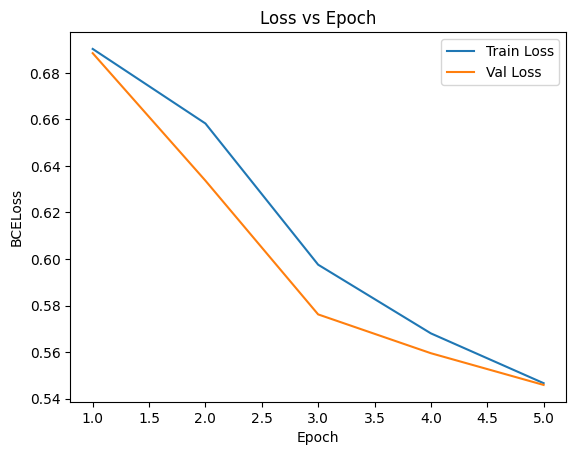

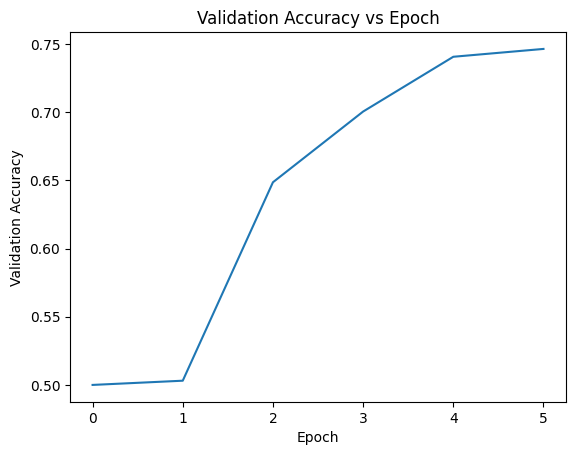

In [20]:
epochs = [i for i in range(1, n_epochs+1)]

figure_1 = plt.figure()
plt.plot(epochs, e_train_losses)
plt.plot(epochs, e_val_losses)
plt.xlabel('Epoch')
plt.ylabel('BCELoss')
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Loss vs Epoch')
plt.show()

figure_2 = plt.figure()
plt.plot([0] + epochs, e_val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.show()

## Test the model
Show model performance on test dataset and plots

In [19]:
test_outputs = []
targets = []
model.eval()

for x, y in tqdm(test_loader):
    x = x.to(model.device)
    y = y.to(model.device)

    with torch.no_grad():
        y_hat = model(x)
        y_hat = torch.round(y_hat)
        
        #test_outputs.append(y_hat)
        targets.append(y)
        test_outputs.append((y_hat == y).float().mean())

print(f'Test Accuracy: {np.array(test_outputs).mean():.3f}')

100%|██████████| 27/27 [00:25<00:00,  1.06it/s]

Test Accuracy: 0.768


In [23]:
# Build plots
ys = None
y_hats = None

for i, (x, y) in enumerate(test_loader):
    # Only collect 1 samples
    if i == 1:
        break
        
    with torch.no_grad():
        y_hat = model(x)
        y_hat = torch.round(y_hat)
        
    if ys is None:
        ys = y.view(-1)
        y_hats = y_hat.view(-1)
    else:
        ys = torch.cat([ys, y.view(-1)], dim=0)
        y_hats = torch.cat([y_hats, y_hat.view(-1)], dim=0)

Text(0.5, 1.0, 'Label vs Time in Test Set Sample Sequence')

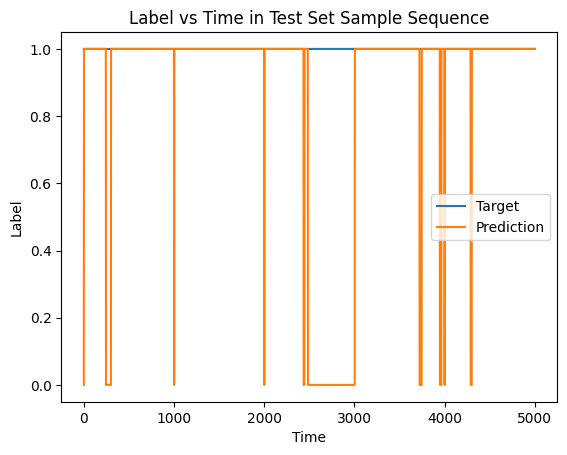

In [149]:
plot_window_size=5000

i=3
fig = plt.figure()
plt.plot(ys[plot_window_size*i:plot_window_size*i+plot_window_size])
plt.plot(y_hats[plot_window_size*i:plot_window_size*i+plot_window_size])
plt.legend(['Target', 'Prediction'])
plt.xlabel('Time')
plt.ylabel('Label')
plt.title('Label vs Time in Test Set Sample Sequence')

## Experiment: Smoothing outputs with low-pass filter

In [147]:
sos = signal.butter(1, 2, 'lp', fs=1/0.002, output='sos')
smoothed_outputs = signal.sosfilt(sos, y_hats)
smoothed_outputs = np.round(smoothed_outputs)

Text(0.5, 1.0, 'Label vs Time in Test Set Sample Sequence')

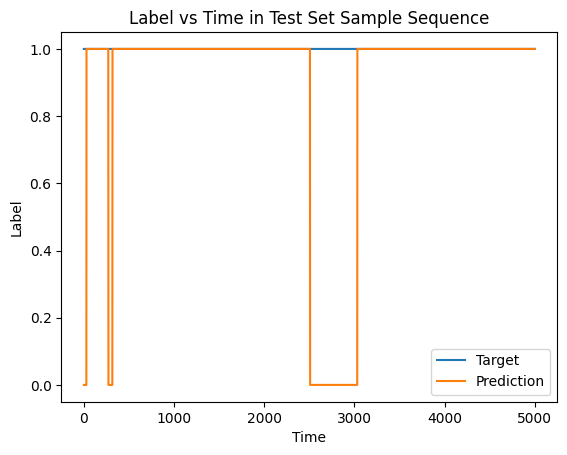

In [148]:
plot_window_size=5000

i=3
fig = plt.figure()
plt.plot(ys[plot_window_size*i:plot_window_size*i+plot_window_size])
plt.plot(smoothed_outputs[plot_window_size*i:plot_window_size*i+plot_window_size])
plt.legend(['Target', 'Prediction'])
plt.xlabel('Time')
plt.ylabel('Label')
plt.title('Label vs Time in Test Set Sample Sequence')

In [145]:
test_acc_with_smoothed = (ys.numpy()==smoothed_outputs).mean()
print(f'Test Accuracy with Smoothed Labels: {test_acc_with_smoothed:.3f}')

Test Accuracy with Smoothed Labels: 0.799
